In [106]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb


import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-shopping-reviews-daily-updated/amazon_reviews.csv


In [107]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Traditional ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import re
import emoji


In [108]:
pip install langdetect

Note: you may need to restart the kernel to use updated packages.


In [126]:
pip install vaderSentiment


Note: you may need to restart the kernel to use updated packages.


# Load Data

In [110]:
#load dataset
df = pd.read_csv('/kaggle/input/amazon-shopping-reviews-daily-updated/amazon_reviews.csv')
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,13939ab0-c597-4302-8291-7566037b45e4,Jim VanSant,"Short Cuts have been changed, an extra step wa...",3,0,30.5.0.100,2025-03-19 13:58:27,30.5.0.100
1,556f75f5-582c-47b8-a00c-c47f6b681b3e,Ayden Majors,it's so like they got everything you want,5,0,NaN,2025-03-19 13:53:02,NaN
2,25f64d38-2c37-48e1-8825-d33f139e4600,Rolando Corchete Guerra,"problem with delivery, 3 days waiting, and the...",1,0,30.5.0.100,2025-03-19 13:33:25,30.5.0.100
3,36900f60-3f70-4b0d-ac31-f68f6709db56,Efrain Ramos,The most Trash Shipping system ever on a platf...,1,0,30.5.0.100,2025-03-19 13:27:38,30.5.0.100
4,59ff98fd-8a05-4194-a8b1-56e232a5a05f,GentleHands Janik,I love shopping on Amazon.,5,0,30.5.0.100,2025-03-19 12:59:13,30.5.0.100


In [111]:
print(df.shape)

print("--------------")

#check data info
df.info()

(71434, 8)
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71434 entries, 0 to 71433
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              71434 non-null  object
 1   userName              71429 non-null  object
 2   content               71429 non-null  object
 3   score                 71434 non-null  int64 
 4   thumbsUpCount         71434 non-null  int64 
 5   reviewCreatedVersion  63617 non-null  object
 6   at                    71434 non-null  object
 7   appVersion            63617 non-null  object
dtypes: int64(2), object(6)
memory usage: 4.4+ MB


In [112]:
# mising data
df.isnull().sum()

reviewId                   0
userName                   5
content                    5
score                      0
thumbsUpCount              0
reviewCreatedVersion    7817
at                         0
appVersion              7817
dtype: int64

In [113]:
# code to count duplicates
duplicates = df[df.duplicated()]
print("Number of duplicate rows:", len(duplicates))

Number of duplicate rows: 114


In [114]:
# check the data statistics
df.describe()

,score,thumbsUpCount
count,71434.000000,71434.000000
mean,2.573550,10.548926
std,1.714598,78.861552
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,5.000000,2.000000
max,5.000000,5660.000000


In [115]:
#subset the relevant features from original data
df = df[['content','score']]
df.head()

,content,score
0,"Short Cuts have been changed, an extra step wa...",3
1,it's so like they got everything you want,5
2,"problem with delivery, 3 days waiting, and the...",1
3,The most Trash Shipping system ever on a platf...,1
4,I love shopping on Amazon.,5


# Data Preprocessing

In [116]:
# Remove duplicate rows based on 'content' (keeping the first occurrence)
df = df.drop_duplicates(subset='content', keep='first')

# Remove rows where 'content' or 'score' is missing (NaN values)
df = df.dropna(subset=['content', 'score'])

# Reset index after dropping rows
df = df.reset_index(drop=True)

# Display the cleaned DataFrame info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69131 entries, 0 to 69130
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  69131 non-null  object
 1   score    69131 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None


In [118]:
# convert test content to lower case
df['content'] = df['content'].str.lower()

In [119]:
# Code to clean the non-english comment from the data
from langdetect import detect
import langdetect

def is_english(text):
    try:
        return detect(text) == "en"  # Check if the detected language is English
    except langdetect.lang_detect_exception.LangDetectException:
        return False  # Return False if language detection fails

# Apply the function to filter only English reviews
df = df[df['content'].apply(is_english)]

# Reset index after filtering
df = df.reset_index(drop=True)

# Display cleaned DataFrame
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65842 entries, 0 to 65841
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  65842 non-null  object
 1   score    65842 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB
None


In [120]:
# Function to remove emojis,spaces,retain only letters
def remove_emojis(text):
    return emoji.replace_emoji(text, replace="")  # Removes emojis

# Function to clean text
def clean_text(text):
    text = remove_emojis(text)  # Remove emojis
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text.lower()

# Apply cleaning
df['cleaned_content'] = df['content'].apply(clean_text)

# Feature Engineering

score
1    31816
5    15960
2     7811
3     5950
4     4305
Name: count, dtype: int64
-------------------


<Axes: xlabel='score', ylabel='count'>

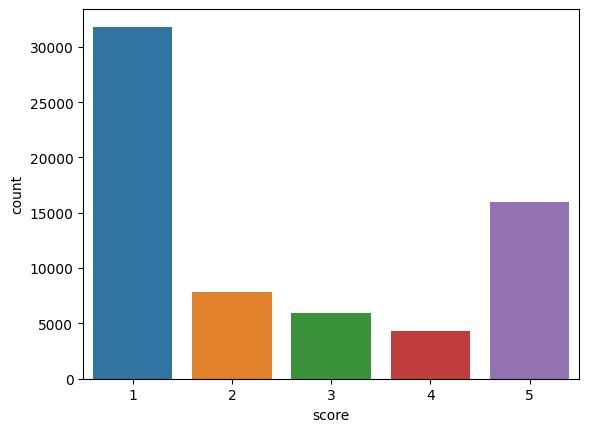

In [121]:
print(df['score'].value_counts())

print('-------------------')
#plot graph
sns.countplot(data=df, x= 'score')

sentiment
0    39627
1    26215
Name: count, dtype: int64
-------------------


<Axes: xlabel='sentiment', ylabel='count'>

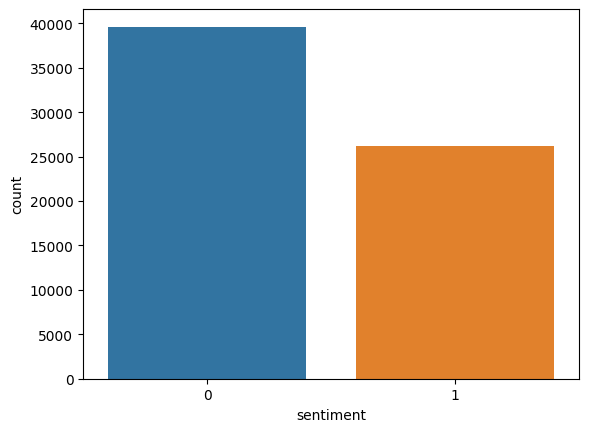

In [122]:
# Encode target: Assuming scores >= 3 are positive, < 3 are negative
df['sentiment'] = df['score'].apply(lambda x: 1 if x >= 3 else 0)  # Adjust based on your dataset

print(df['sentiment'].value_counts())

print('-------------------')
#plot graph
sns.countplot(data=df, x= df['sentiment'])

# Data Splitting
I'll stratify 10% of the data for initial testing before full training.

In [124]:
print(df['sentiment'].value_counts())


sentiment
0    39627
1    26215
Name: count, dtype: int64


In [125]:
# Split into stratified data for initial testing
df_train, df_test = train_test_split(df, test_size=0.5, stratify=df['sentiment'], random_state=42)

# Sentiment Analysis Models
We'll evaluate Rule-Based, Machine Learning, and Deep Learning methods.

🔹 3.1 Rule-Based Approach (Lexicon-Based)
Using VADER from nltk

In [128]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Function to map VADER to 0 or 1
def get_vader_binary_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    return 1 if score >= 0 else 0  # Assign 1 to positive sentiment, 0 to negative

# Apply VADER
df_test['vader_prediction'] = df_test['cleaned_content'].apply(get_vader_binary_sentiment)

# Calculate Accuracy
vader_accuracy = (df_test['vader_prediction'] == df_test['score']).mean()
print(f"VADER Accuracy: {vader_accuracy:.4f}")


VADER Accuracy: 0.1970


# Machine Learning-Based Approach
Using TF-IDF + Logistic Regression

In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Vectorization
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['cleaned_content'])
X_test = vectorizer.transform(df_test['cleaned_content'])

# Train Logistic Regression Model
lr_model = LogisticRegression()
lr_model.fit(X_train, df_train['sentiment'])

# Predictions
lr_predictions = lr_model.predict(X_test)

# Evaluation
print("Logistic Regression Performance:\n", classification_report(df_test['sentiment'], lr_predictions))


Logistic Regression Performance:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89     19814
           1       0.89      0.74      0.80     13107

    accuracy                           0.86     32921
   macro avg       0.86      0.84      0.85     32921
weighted avg       0.86      0.86      0.85     32921



# Deep Learning-Based Approach
Using LSTM (TensorFlow/Keras)

In [130]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split

# Label Mapping
label_mapping = {'negative': 0, 'positive': 1}

# Ensure 'sentiment' column has valid values
df = df[df['sentiment'].isin(label_mapping.keys())]

# Convert labels to numeric
df['sentiment'] = df['sentiment'].map(label_mapping)

# Remove missing values
df = df.dropna(subset=['cleaned_content', 'sentiment'])

# Train-Test Split (Stratified)
#df_train, df_test = train_test_split(df, test_size=0.1, stratify=df['sentiment'], random_state=42)

# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['cleaned_content'])

X_train_seq = tokenizer.texts_to_sequences(df_train['cleaned_content'])
X_test_seq = tokenizer.texts_to_sequences(df_test['cleaned_content'])

# Padding
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Get labels
y_train = df_train['sentiment'].values
y_test = df_test['sentiment'].values

# LSTM Model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

# Evaluate Model
train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Testing Accuracy: {test_acc:.4f}")


Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5904 - loss: 0.6905 - val_accuracy: 0.8186 - val_loss: 0.4647
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8359 - loss: 0.4015 - val_accuracy: 0.8583 - val_loss: 0.3377
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8793 - loss: 0.2959 - val_accuracy: 0.8604 - val_loss: 0.3442
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9023 - loss: 0.2432 - val_accuracy: 0.8519 - val_loss: 0.3588
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9126 - loss: 0.2152 - val_accuracy: 0.8499 - val_loss: 0.3889
Epoch 6/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9245 - loss: 0.1856 - val_accuracy: 0.8510 - val_loss: 0.4308
Epoch 7/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9398 - loss: 0.1568 - val_accuracy: 0.8436 - val_loss: 0.4662
Epoch 8/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9510 -

# Conclusion
Based on the above, the best accuracy was from Logistic Regressions at 86%.

Note:
The model could be further  optimized.